<a href="https://colab.research.google.com/github/AshikaKannan/AshikaKannan/blob/main/GenAI_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overall Probabilities:
  Student_ID             College_Name  Overall_Probability
0     ST0001       Harvard University                  1.0
1     ST0001      Stanford University                  1.0
2     ST0001                      MIT                  1.0
3     ST0001     University of Oxford                  1.0
4     ST0001  University of Cambridge                  1.0
Recommended Colleges:
               College_Name  Overall_Probability  Financial_Probability  \
0                 IIT Delhi                  1.0                    0.4   
1                       NUS                  1.0                    0.4   
2   University of Melbourne                  1.0                    0.4   
3                IIT Bombay                  1.0                    0.4   
4           Anna University                  1.0                    0.4   
5     University of Chicago                  0.8                    0.4   
6        Harvard University                  0.8                    0.4   
7

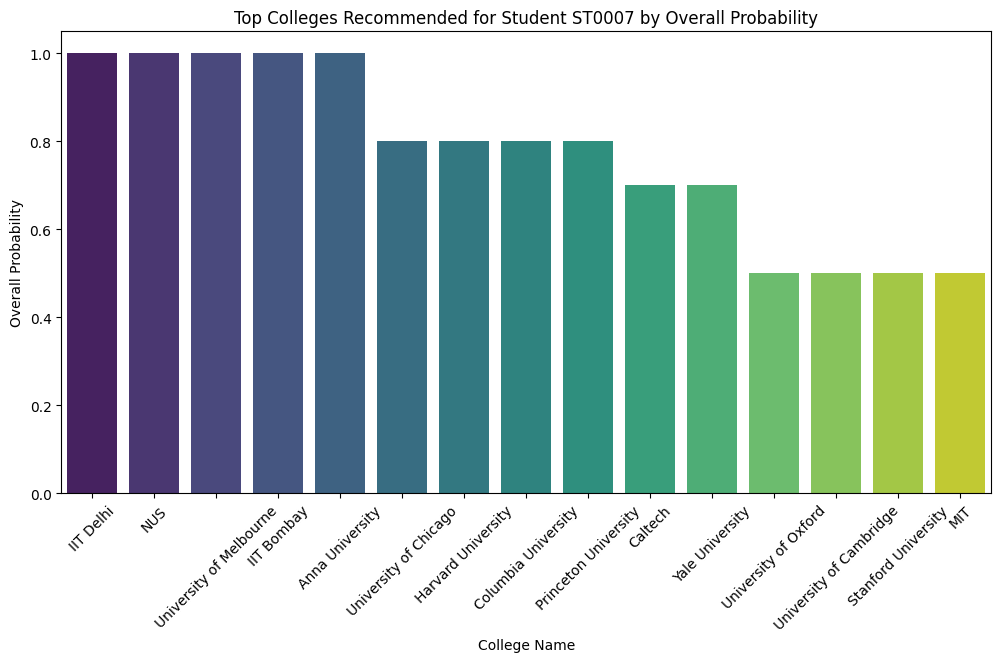

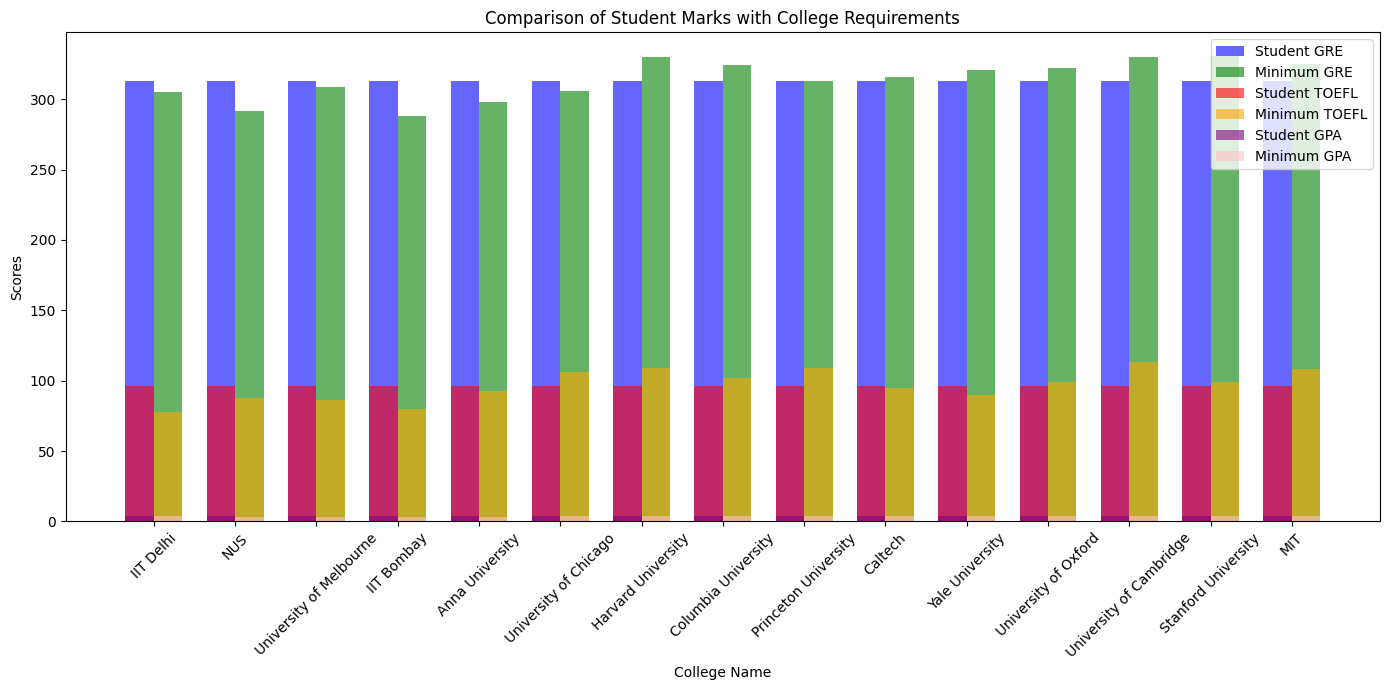

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
students_df = pd.read_csv('students.csv')
colleges_df = pd.read_csv('colleges.csv')

# Create a complete dataset for all students and colleges using cross join
student_college = pd.merge(students_df, colleges_df, how='cross')

# Feature engineering for calculating probabilities for all colleges
def calculate_probabilities(row):
    base_prob = 0.5  # Base acceptance probability

    # Increase probability based on GRE
    if row['GRE'] >= row['Minimum_GRE']:
        base_prob += 0.3

    # Increase probability based on GPA
    if row['GPA'] >= row['Minimum_GPA']:
        base_prob += 0.3

    # Increase probability based on TOEFL
    if row['TOEFL'] >= row['Minimum_TOEFL']:
        base_prob += 0.2

    # Check for scholarships
    if row['Available_Scholarships'] and row['Scholarship_Availability']:
        base_prob += 0.2

    # Check course availability
    courses_offered = row['Available_Courses'].split(', ')
    if row['Preferred_Course'] in courses_offered:
        base_prob += 0.3

    return min(base_prob, 1.0)  # Ensure probabilities do not exceed 1.0

# Apply the function to calculate probabilities for all college options
student_college['Overall_Probability'] = student_college.apply(calculate_probabilities, axis=1)

# Debug: Check the calculated probabilities
print("Overall Probabilities:")
print(student_college[['Student_ID', 'College_Name', 'Overall_Probability']].head())

# Function to calculate financial probability based on affordability rating
def financial_probability(row):
    if row['Financial_Affordability_Rating'] == 'High':
        return 0.9
    elif row['Financial_Affordability_Rating'] == 'Medium':
        return 0.7
    else:
        return 0.4

# Apply financial probability calculation
student_college['Financial_Probability'] = student_college.apply(financial_probability, axis=1)

# Educational probability calculation
student_college['Educational_Probability'] = (student_college['Overall_Probability'] + student_college['Financial_Probability']) / 2

# Function to get recommendations for a specific student
def get_recommendations(student_id):
    recommendations = student_college[student_college['Student_ID'] == student_id][
        ['College_Name', 'Overall_Probability', 'Financial_Probability', 'Educational_Probability',
         'GRE', 'TOEFL', 'GPA', 'Minimum_GRE', 'Minimum_TOEFL', 'Minimum_GPA']]

    # Sort by Overall Probability and get top recommendations
    top_recommendations = recommendations.sort_values(by='Overall_Probability', ascending=False)

    return top_recommendations

# Example: Get recommendations for a specific student
student_id_to_check = 'ST0007'  # Replace with the ID of the student you want to check
top_recommendations_for_student = get_recommendations(student_id_to_check)

# Display top recommendations for the specific student
print("Recommended Colleges:")
print(top_recommendations_for_student.reset_index(drop=True))

# Visualization for the specific student's recommendations
plt.figure(figsize=(12, 6))
sns.barplot(data=top_recommendations_for_student, x='College_Name', y='Overall_Probability', palette='viridis')
plt.title(f'Top Colleges Recommended for Student {student_id_to_check} by Overall Probability')
plt.xticks(rotation=45)
plt.ylabel('Overall Probability')
plt.xlabel('College Name')
plt.show()

# Visualization of students' marks vs. college expectations
num_recommendations = top_recommendations_for_student.shape[0]
bar_width = 0.35
index = np.arange(num_recommendations)

# Create figure and axes
plt.figure(figsize=(14, 7))

# Marks for the student
plt.bar(index, top_recommendations_for_student['GRE'], bar_width, label='Student GRE', color='b', alpha=0.6)
plt.bar(index + bar_width, top_recommendations_for_student['Minimum_GRE'], bar_width, label='Minimum GRE', color='g', alpha=0.6)

plt.bar(index, top_recommendations_for_student['TOEFL'], bar_width, label='Student TOEFL', color='r', alpha=0.6)
plt.bar(index + bar_width, top_recommendations_for_student['Minimum_TOEFL'], bar_width, label='Minimum TOEFL', color='orange', alpha=0.6)

plt.bar(index, top_recommendations_for_student['GPA'], bar_width, label='Student GPA', color='purple', alpha=0.6)
plt.bar(index + bar_width, top_recommendations_for_student['Minimum_GPA'], bar_width, label='Minimum GPA', color='pink', alpha=0.6)

plt.xlabel('College Name')
plt.ylabel('Scores')
plt.title('Comparison of Student Marks with College Requirements')
plt.xticks(index + bar_width / 2, top_recommendations_for_student['College_Name'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
